# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-12-19*

In [1]:
import os
import numpy as np
import pandas as pd

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import average_data
from spatial import plot_map_withobs, plot_diff_withobs

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

因观测站点在逐年增加，为了方便比较和绘图，仅比较1399A号及以前的站点，其后增加的站点（2019前缺失）不考虑；具体各城市站点变化如下\
东莞+3，中山+1， 佛山+1， 广州+11， 惠州+2， 江门+2， 深圳+5， 珠海+2， 肇庆+3\
珠三角现在共有85个站点，我们选取其中的55个站点绘图

In [2]:
sitelocation = pd.read_excel(obs_dir + 'sitelocation.xlsx')
sitelocation = sitelocation.iloc[:55,:]
site_group = sitelocation.groupby('城市')
city_site = {}
for group in site_group.groups:
    city_site[group] = site_group.get_group(group)['监测点编码'].values
city_site

{'东莞': array(['1387A', '1388A', '1389A', '1390A', '1391A'], dtype=object),
 '中山': array(['1379A', '1380A', '1381A', '1382A'], dtype=object),
 '佛山': array(['1371A', '1372A', '1373A', '1374A', '1375A', '1376A', '1377A',
        '1378A'], dtype=object),
 '广州': array(['1345A', '1346A', '1347A', '1348A', '1349A', '1350A', '1351A',
        '1352A', '1353A', '1354A', '1355A'], dtype=object),
 '惠州': array(['1392A', '1393A', '1394A', '1395A', '1396A'], dtype=object),
 '江门': array(['1383A', '1384A', '1385A', '1386A'], dtype=object),
 '深圳': array(['1356A', '1357A', '1358A', '1359A', '1360A', '1361A', '1362A',
        '1363A', '1364A', '1365A', '1366A'], dtype=object),
 '珠海': array(['1367A', '1368A', '1369A', '1370A'], dtype=object),
 '肇庆': array(['1397A', '1398A', '1399A'], dtype=object)}

In [3]:
sitenum = sitelocation['监测点编码'].values
sitelon = sitelocation['经度'].values
sitelat = sitelocation['纬度'].values

In [4]:
var = 'O3'
years = np.array([2022,2021,2019])

# =======================================
# Observation data
# =======================================

dfs = []
obspath = get_obspath('Jul')
for year in years: 
    df = pd.read_excel(obspath + f'site_{var}_{year}.xlsx',index_col=0)
    df = df[sitenum].reset_index()
    df.drop(columns='index',inplace=True)
    dfs.append(df)
    
merged_df = pd.concat(dfs)
obs_summer   = merged_df.groupby(level=0).mean()

dfs = []
obspath = get_obspath('Sep')
for year in years: 
    df = pd.read_excel(obspath + f'site_{var}_{year}.xlsx',index_col=0)
    df = df[sitenum].reset_index()
    df.drop(columns='index',inplace=True)
    dfs.append(df)
    
merged_df = pd.concat(dfs)
obs_autumn  = merged_df.groupby(level=0).mean()

# =======================================
# Simulation data
# =======================================

summer_files = [os.path.join(processed_dir, f"Jul_{year}/Jul_{year}_chem.nc") for year in years]
autumn_files = [os.path.join(processed_dir, f"Sep_{year}/Sep_{year}_chem.nc") for year in years]
summer_wind  = [os.path.join(processed_dir, f"Jul_{year}/Jul_{year}_mcip.nc") for year in years]
autumn_wind  = [os.path.join(processed_dir, f"Sep_{year}/Sep_{year}_mcip.nc") for year in years]

sim_summer    = average_data(summer_files, var)
sim_autumn    = average_data(autumn_files, var)
sim_summer_uw = average_data(summer_wind, 'uwind')
sim_autumn_uw = average_data(autumn_wind, 'uwind')
sim_summer_vw = average_data(summer_wind, 'vwind')
sim_autumn_vw = average_data(autumn_wind, 'vwind')


In [7]:
obs_summer.index = pd.date_range('2023-07-01T00','2023-07-31T23',freq='H')
obs_autumn.index = pd.date_range('2023-09-01T00','2023-09-30T23',freq='H')
avg_obs_summer   = obs_summer.rolling(8).mean().resample('D').max().mean(axis=0)
avg_obs_autumn   = obs_autumn.rolling(8).mean().resample('D').max().mean(axis=0)

avg_sim_summer = sim_summer.rolling(time=8).mean(dim='time').resample(time='D').max(dim='time').mean(dim='time')
avg_sim_autumn = sim_autumn.rolling(time=8).mean(dim='time').resample(time='D').max(dim='time').mean(dim='time')

uwind_summer = sim_summer_uw.mean(dim='time')
uwind_autumn = sim_autumn_uw.mean(dim='time')
vwind_summer = sim_summer_vw.mean(dim='time')
vwind_autumn = sim_autumn_vw.mean(dim='time')

In [8]:
cmin=80
cmax=200
cmstep=1
cbstep=40

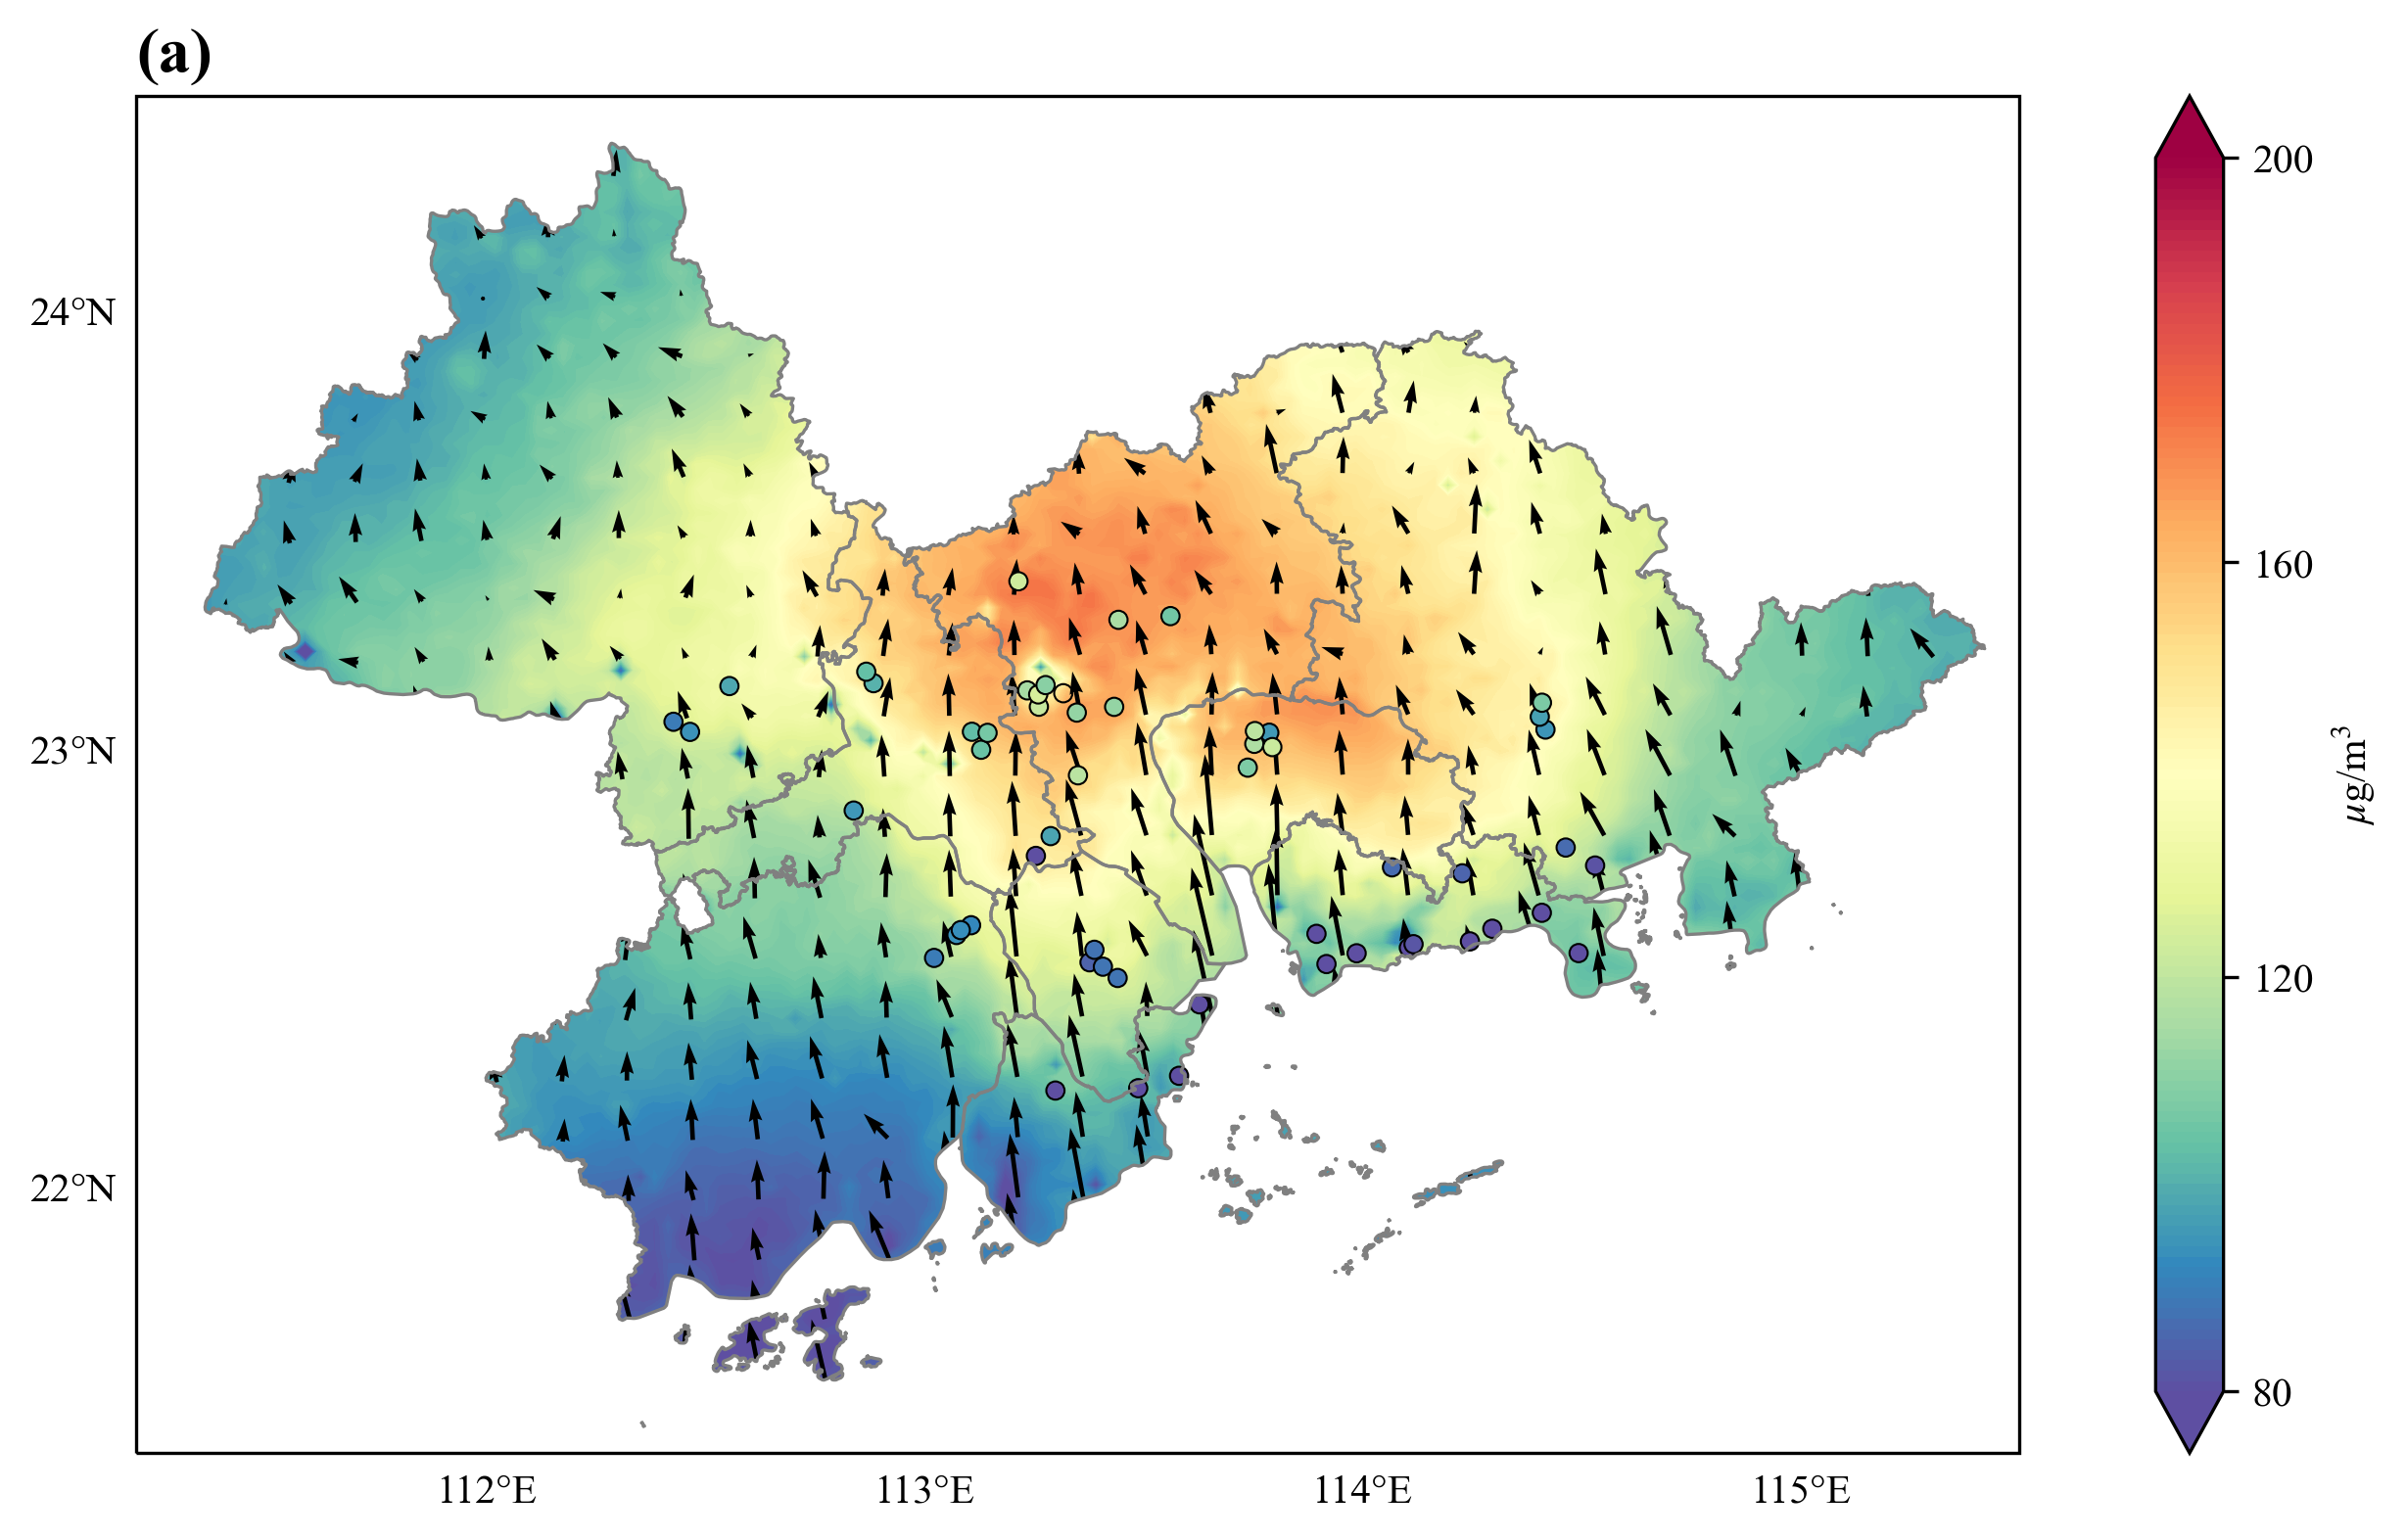

In [9]:
plot_map_withobs(sim_summer, cmin, cmax, cmstep, cbstep,
             avg_sim_summer, uwind_summer, vwind_summer,
             avg_obs_summer, sitelon, sitelat,
             ngrid=5, scale=100, headwidth=3,
             title='(a)', colorbar_label='$\mu$g/m$^3$')

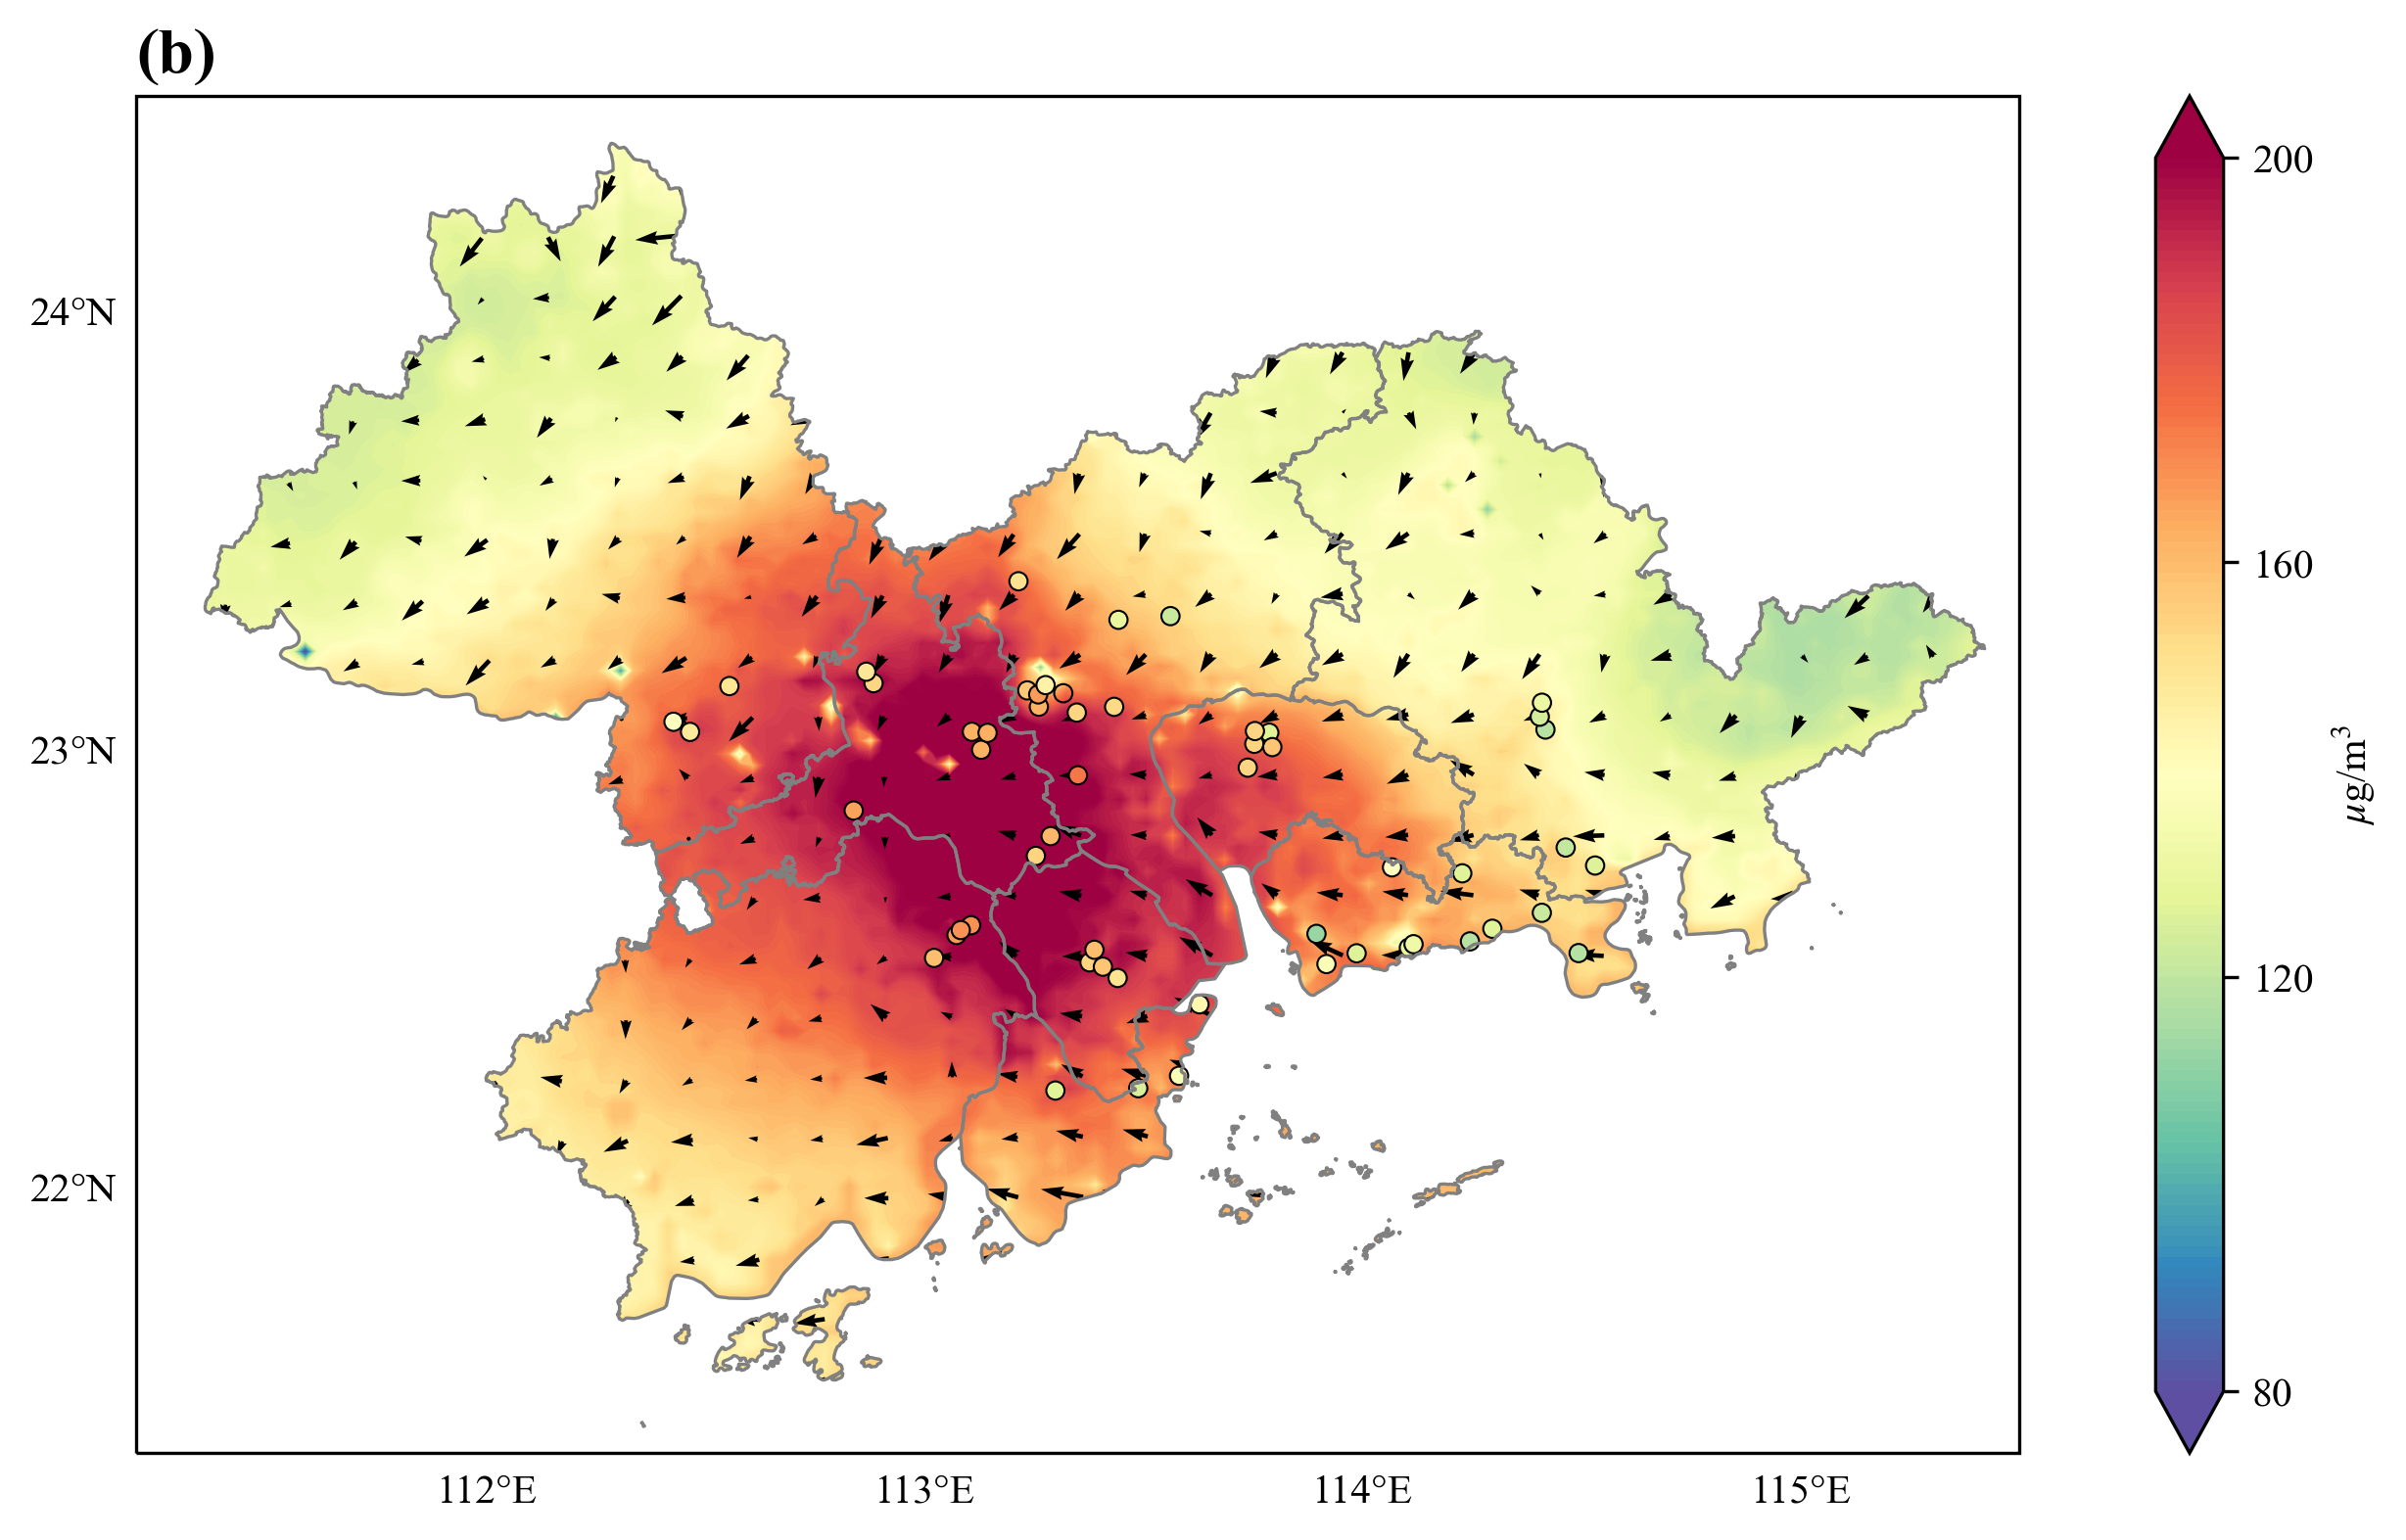

In [10]:
plot_map_withobs(sim_autumn, cmin, cmax, cmstep, cbstep,
             avg_sim_autumn, uwind_autumn, vwind_autumn,
             avg_obs_autumn, sitelon, sitelat,
             ngrid=5, scale=100, headwidth=3,
             title='(b)', colorbar_label='$\mu$g/m$^3$')

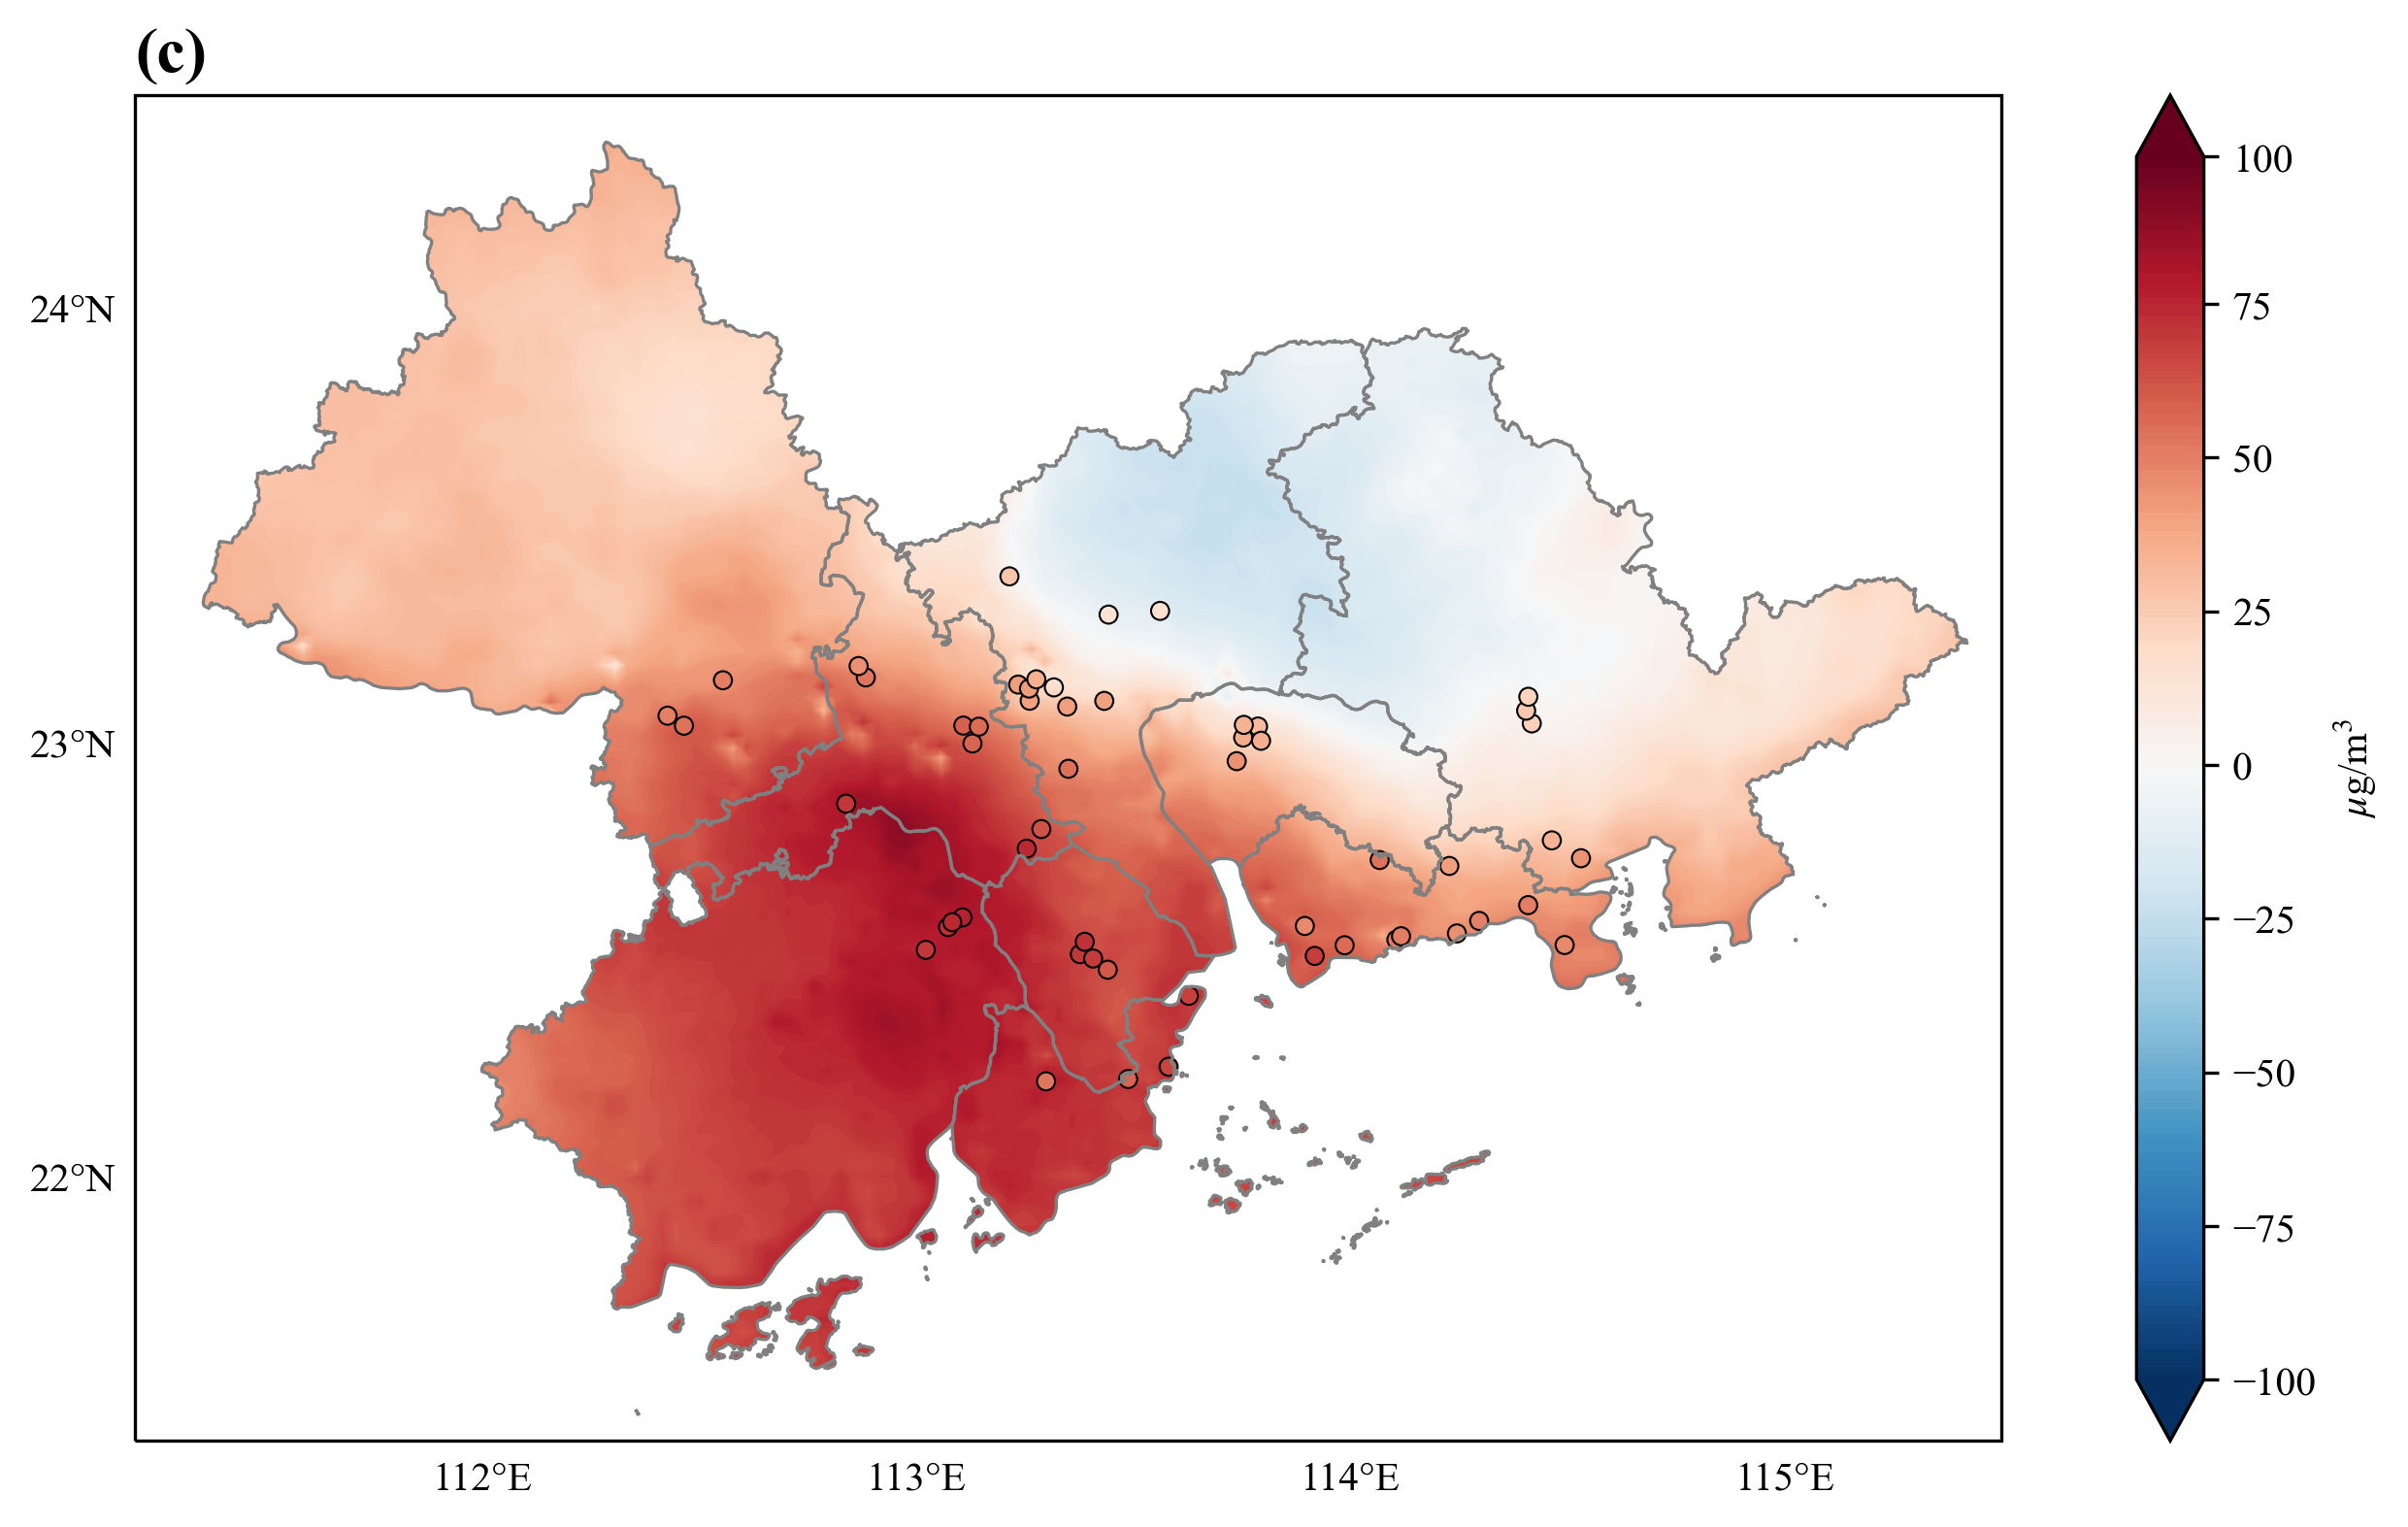

In [13]:
cmin = -100
cmax = 100
cmstep = 1
cbstep = 25

plot_diff_withobs(sim_autumn, cmin, cmax, cmstep, cbstep,
              avg_sim_summer, avg_sim_autumn,
              avg_obs_summer,avg_obs_autumn,sitelon,sitelat,
              title='(c)', colorbar_label='$\mu$g/m$^3$')